## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
# cd ..
%cd /home/jovyan/dea_intertidal/dea-intertidal

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
pip install -r requirements.in --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandana 0.6.1 requires tables<3.7,>=3.1; python_version >= "3.6", but you have tables 3.7.0 which is incompatible.
awscli 1.25.60 requires PyYAML<5.5,>=3.10, but you have pyyaml 6.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


### Load packages

In [3]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
import odc.geo.xr
from tqdm import tqdm
from odc.algo import mask_cleanup, xr_quantile
from concurrent.futures import ProcessPoolExecutor

from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides, model_tides
from intertidal.elevation import (load_data, 
                                  ds_to_flat, 
                                  pixel_rolling_median,
                                  pixel_dem,
                                  elevation
                                 )
from intertidal.extents import extents
from intertidal.utils import load_config
from intertidal.exposure import pixel_exp
from intertidal.tidal_bias_offset import bias_offset
from intertidal.tidelines import tidal_offset_tidelines

# cluster = create_dask_gateway_cluster(profile="r5_4XL", workers=10)
# print("Dashboard", cluster.dashboard_link)
# client = cluster.get_client()

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

# Connect to datacube
dc = datacube.Datacube(app='Intertidal_elevation')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37775,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:36777,Total threads: 62
Dashboard: /user/claire.phillips@ga.gov.au/proxy/37039/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:41565,


## Setup


### Set analysis parameters

In [169]:
study_area = 'Waterbank_WA'#1215 #340
## 815: South Gladstone, QLD 
## 477: Albert River, Gulf of C., NT 
## 481:Kurumba,Qld 
## 507: Roebuck Bay (also 506, 519)
## Sites to trial:
# QLD 584, 614, 684, 800 Upper Gladstone, 892 Moreton Bay
# NSW 1084,1152,1111, 1044, 1008, 915
# VIC 1170, 1215
# TAS 1233, 1235, 1268, 1281, 1289, 1269
# SA 1162, 1154, 1138, 1066, 1006, 976
# WA south 950, 1027/8 and 1032 problem region
# WA mid 839, 848
# WA north: 456 (Cambridge gulf), 437

## Nidem variables
fname = 'testing_WaterbankWA'
start_year = 2016
end_year = 2021
resolution = 10 
crs = "epsg:32753"
ndwi_thresh = 0.1
include_s2 = True
include_ls = True
filter_gqa = False

## Exposure variables
## Tidal modelling period. Format: 'YYYY-MM-DD HH:MM:SS'
time_start = '2001-01-01 00:00:00'
time_end = '2021-12-31 00:00:00'

## Set the frequency to run the tidal model e.g '30min' or '1h'
modelled_freq='30min'

# Generate range of times covering entire period of satellite record
all_timerange = pd.date_range(start=time_start,
                              end=time_end,
                              freq=modelled_freq)

# Load analysis params from config file
config = load_config(
    config_path='configs/dea_intertidal_config.yaml')

### Load study area grid cell

In [5]:
# # Albers grid cells used to process the analysis
# gridcell_gdf = (
#     gpd.read_file(config['Input files']['grid_path']).to_crs(
#         epsg=4326).set_index('id'))
# gridcell_gdf.index = gridcell_gdf.index.astype(int).astype(str)
# gridcell_gdf = gridcell_gdf.loc[[str(study_area)]]

# # Create geom as input for dc.load
# geom = Geometry(geom=gridcell_gdf.iloc[0].geometry, crs='EPSG:4326')
# geom

##### Other options for loading study area

In [6]:
# # aoi = 'McCarthur River'
# # aoi = 'Greenbank'
# aoi = 'Seven Emu'
# # aoi = 'Wollogorang'

# # Import regions of interest
# aoi_gdf = gpd.read_file('data/raw/Phase_1_NT_Gov.geojson').set_index('Name').to_crs('EPSG:3577')
# aoi_gdf.head()

# # Select AOI
# geom = Geometry(geom=aoi_gdf.loc[aoi].geometry, crs='EPSG:3577')
# geom

In [7]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                       
                             zoom=4)

## Guide: for 10m2 pixels, analysis area of 90km2 takes ~XXXX mins to run full workflow on 16XL sandbox instance

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

# Elevation

In [72]:
ds = xr.Dataset(coords=ds.coords, attrs=ds.attrs, data_vars=ds[['tide_m', 'ndwi']])

In [74]:
ds = elevation(study_area=geom,
               start_year = start_year,
               end_year = end_year)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/35265/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/35265/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34391,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/35265/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:39695,Total threads: 62
Dashboard: /user/claire.phillips@ga.gov.au/proxy/36891/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:39957,


2023-03-27 02:53:29 INFO Study area testing: Loaded custom study area
2023-03-27 02:53:29 INFO Study area testing: Loading satellite data
2023-03-27 02:56:04 INFO Study area testing: Modelling tide heights for each pixel


Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 810/810 [00:11<00:00, 73.00it/s]
2023-03-27 02:56:41 INFO Study area testing: Masking nodata and adding tide heights to satellite data array
2023-03-27 02:56:49 INFO Study area testing: Flattening satellite data array and filtering to tide influenced pixels
2023-03-27 02:57:25 INFO Study area testing: Running per-pixel rolling median


Reducing analysed pixels from 1864080 to 89500 (4.80%)


100%|██████████| 114/114 [02:53<00:00,  1.52s/it]
2023-03-27 03:00:31 INFO Study area testing: Modelling intertidal elevation and confidence


Processing dem_low
Processing dem
Processing dem_high


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-03-27 03:00:34 INFO Study area testing: Successfully completed intertidal elevation modelling


# Intertidal extents

## Always/Sometimes/Never_wet

Values of 0 represent always wet, 1 is the extent of the DEA intertidal product suite and 2 represents never wet

In [75]:
ds = extents(ds)

# Pixel-based intertidal exposure

In [76]:
# ## Calculate exposure using the script function

ds = pixel_exp(ds, all_timerange)

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Computing tide quantiles
Reprojecting tides into original array


100%|██████████| 1001/1001 [00:26<00:00, 37.16it/s]


# Spread and offset

In [104]:
## Calculate the spread and high/low tide biases of input observed images as a 
## percentage of the modelled tide heights

ds = bias_offset(ds,                 
                 # set_dtype=np.int16,
                 LAT_HAT=True,
                 LOT_HOT=True)

# Tideline confidence

In [150]:
hightideline, lowtideline, tidelines_gdf = tidal_offset_tidelines(ds, distance=250)

Operating in multiple z-value, single array mode


In [159]:
# hightideline.to_file('data/interim/Waterbank_WA_hightideoffset.shp')
# lowtideline.to_file('data/interim/Waterbank_WA_lowtideoffset.shp')
# tidelines_gdf.to_file('data/interim/Waterbank_WA_high_0_low_1_tidelines.shp')

<Axes: title={'center': 'Lowtide line and lowtide offset'}>

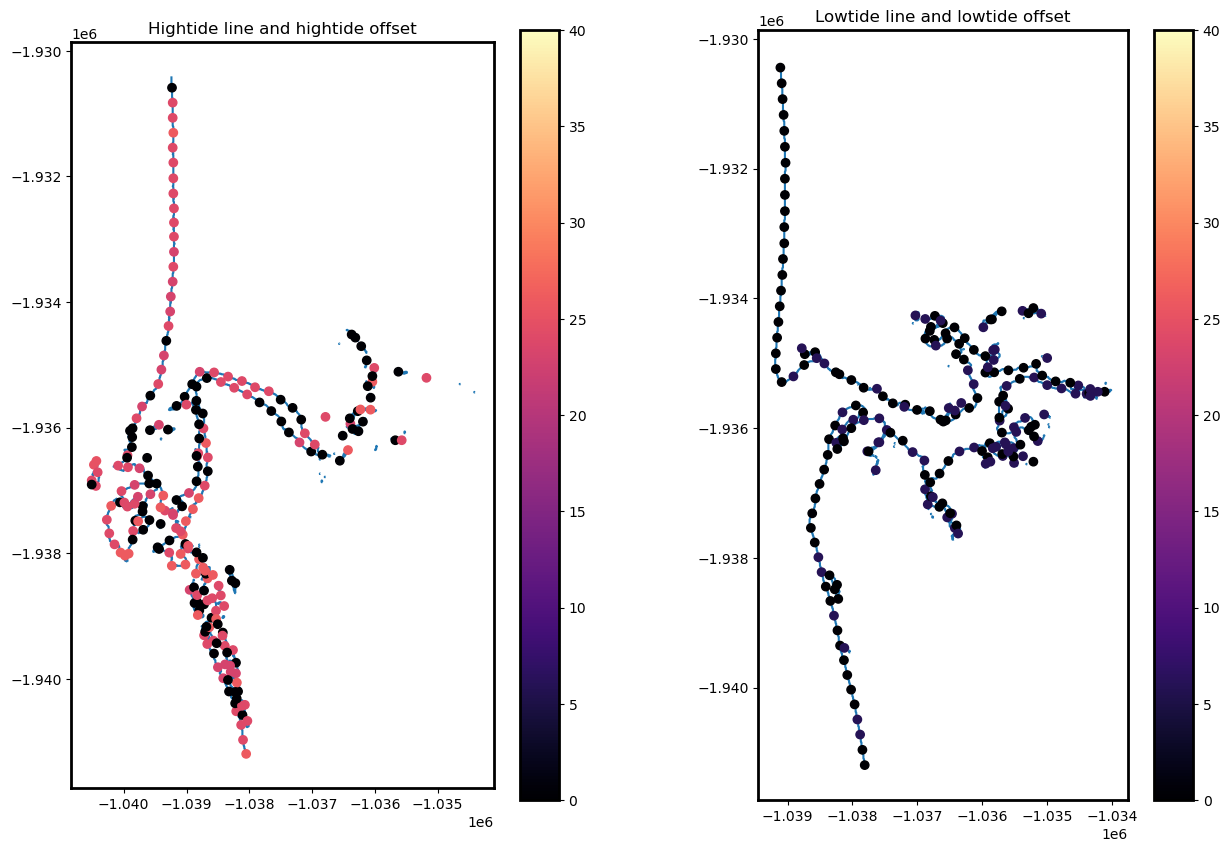

In [151]:
## Plot tidelines and offset values

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax11.set_title('Hightide line and hightide offset')
lowtideline.plot(column='lt_offset', legend=True, vmin=0, vmax=40, cmap='magma', ax=ax11, zorder=2)
tidelines_gdf.loc[[0], 'geometry'].plot(ax=ax11, zorder=1)

ax12.set_title('Lowtide line and lowtide offset')
hightideline.plot(column='ht_offset', legend=True, vmin=0, vmax=40, cmap='magma', ax=ax12, zorder=2)
tidelines_gdf.loc[[1], 'geometry'].plot(ax=ax12, zorder=1)

# Plot all layers

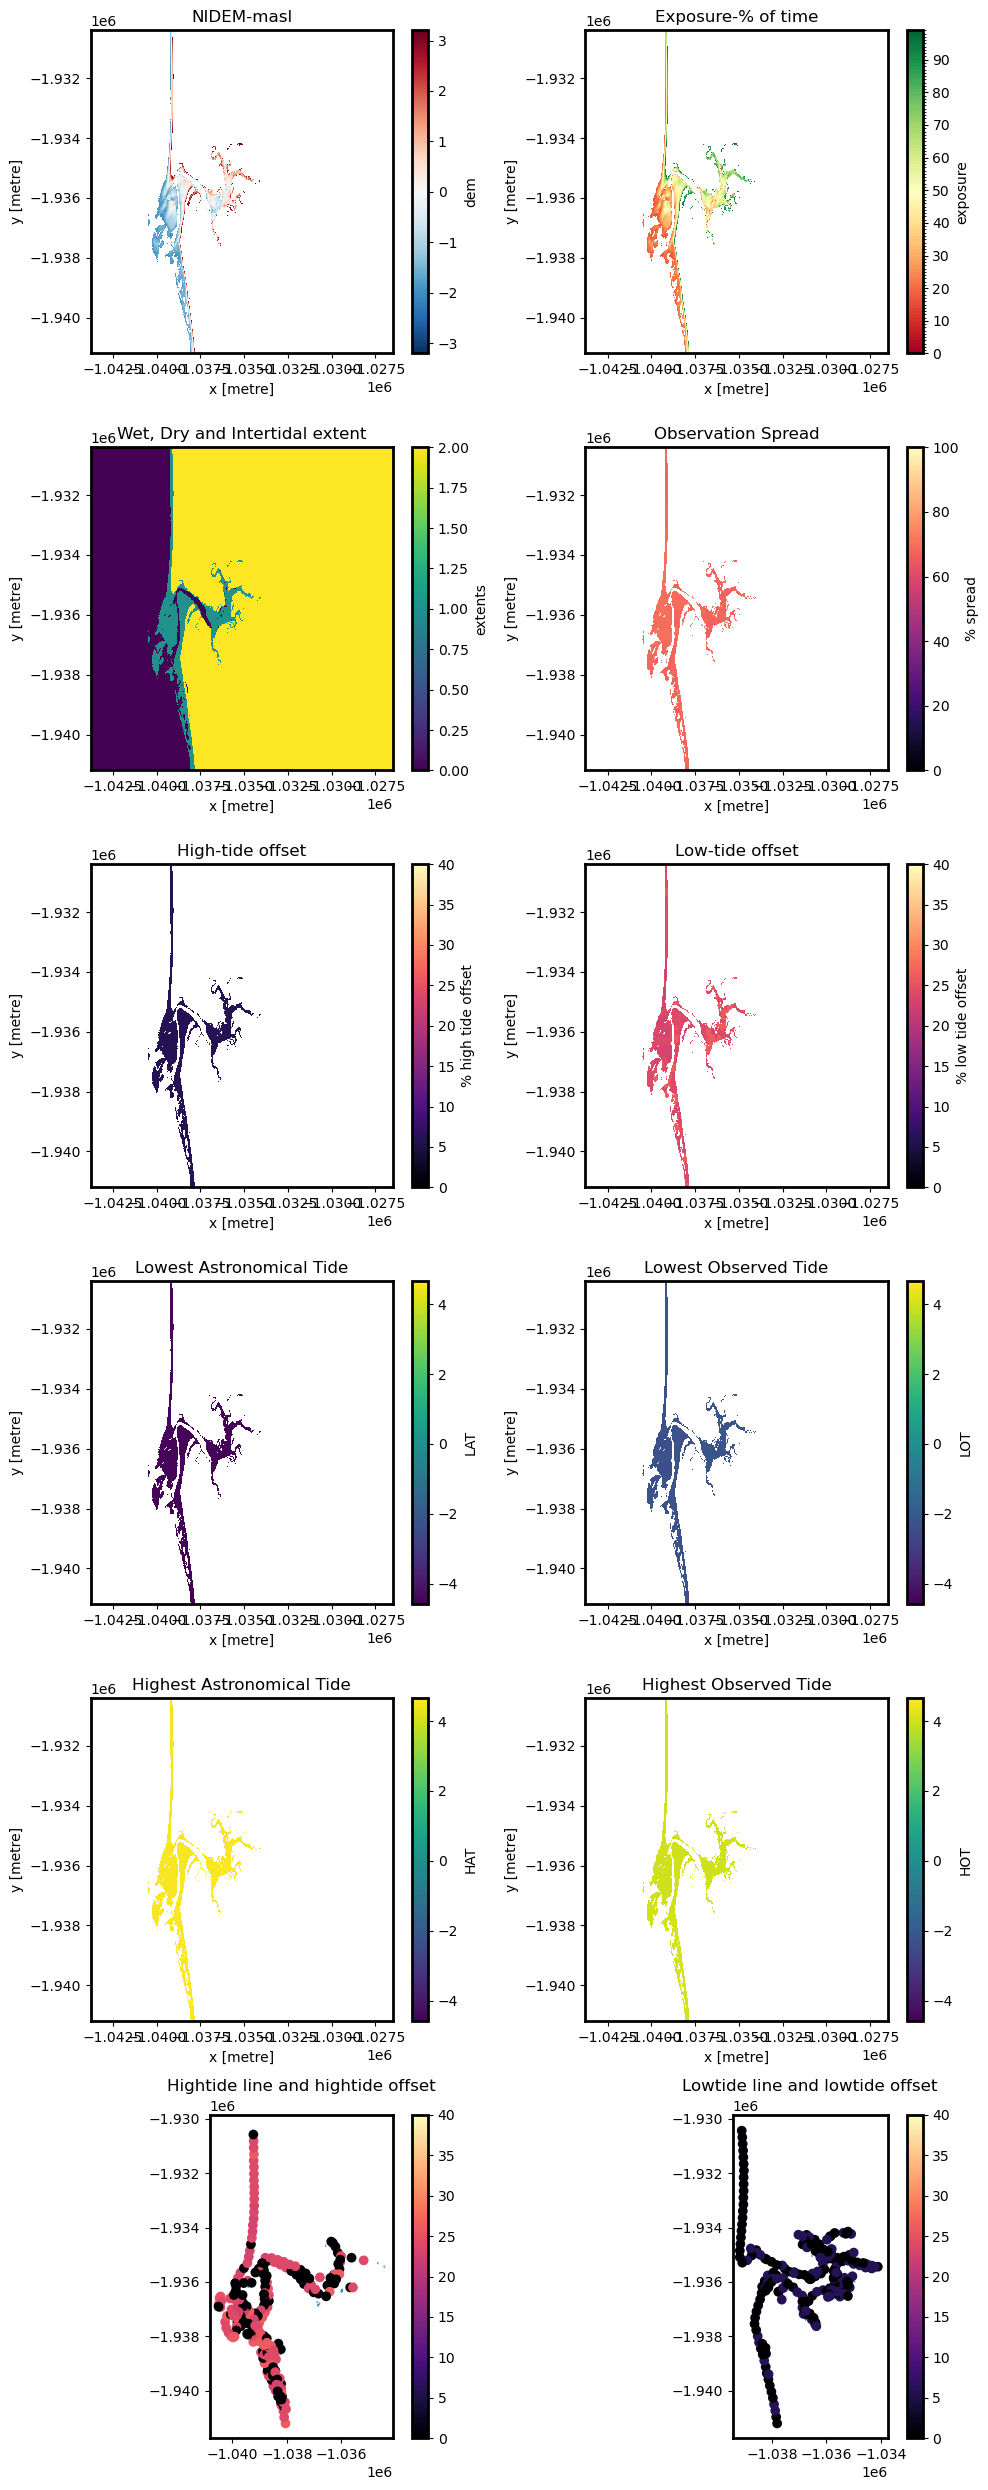

In [166]:
## Plot
# DEM = dem_test.copy(deep=True)
# DEM = dem1.copy(deep=True)

fig = plt.figure(figsize=(10,25))
ax1 = fig.add_subplot(6,2,1)
ax2 = fig.add_subplot(6,2,2)
ax3 = fig.add_subplot(6,2,3)
ax4 = fig.add_subplot(6,2,4)
ax5 = fig.add_subplot(6,2,5)
ax6 = fig.add_subplot(6,2,6)
ax7 = fig.add_subplot(6,2,7)
ax8 = fig.add_subplot(6,2,8)
ax9 = fig.add_subplot(6,2,9)
ax10 = fig.add_subplot(6,2,10)
ax11 = fig.add_subplot(6,2,11)
ax12 = fig.add_subplot(6,2,12)

## Plot NIDEM
ds['dem'].plot(ax=ax1)
ax1.set_title('NIDEM-masl')
# # ax1.legend('Elevation (masl)')
# ax1.clabelcolorbar.set_label('Elevation (masl)')
# plt.colorbar(ax=ax1, label='Elevation (masl)')

## Plot Exposure
ds['exposure'].where(ds['exposure']>0).plot(ax=ax2, cmap='RdYlGn', levels=np.arange(0,100,1))
ax2.set_title('Exposure-% of time')

# ## Plot NIDEM/Exposure correlation
# y=np.linspace((DEM['idxmin']).min(),(DEM['idxmin']).max())#, 100])
# x=np.linspace((DEM['tide_m']).min(),(DEM['tide_m']).max())#, 100])

# ax3.scatter(DEM['tide_m'], DEM['idxmin'], marker='.', label='NIDEM vs Exp')
# ax3.set_title('Correlation')
# ax3.plot(x,y, label='linear', color='red')
# ax3.set_xlabel('NIDEM masl')
# ax3.set_ylabel('Exposure-% time')
# ax3.legend()

# ## Plot histogram of sensor observed exposure pixels
# bins=np.arange(0, 1.1, 0.1)
# y, binedges, _ = xr.plot.hist(DEM['idxmin'], xlim=(0,1), bins=bins)
# bincenters = (0.5*(binedges[1:] + binedges[:-1]))
# category_colors = plt.get_cmap('RdYlGn')(np.arange(0.0, 1.0, 0.1))
# ax4.bar(bincenters, y, width=0.1, color=category_colors)
# ax4.set_title('Sensor observed regions')
# ax4.set_xlabel('Exposure-% time')
# ax4.set_ylabel('Pixel count')

## Plot the always/sometimes/never wet extents
ds['extents'].astype(np.int16).plot(ax=ax3)
ax3.set_title('Wet, Dry and Intertidal extent')

## Plot the observation spread
ds['spread'].where((ds['extents']!=2) & (ds['spread'] > 0)).plot(ax=ax4, vmin=0, vmax=100, cmap='magma', cbar_kwargs={'label': '% spread'})
ax4.set_title('Observation Spread')


## Plot the high-tide offset
ds['ht_offset'].where((ds['extents']!=2) & (ds['spread'] > 0)).plot(ax=ax5, vmin=0, vmax=40, cmap='magma', cbar_kwargs={'label': '% high tide offset'})
ax5.set_title('High-tide offset')

## Plot the low-tide offset
ds['lt_offset'].where((ds['extents']!=2) & (ds['spread'] > 0)).plot(ax=ax6, vmin=0, vmax=40, cmap='magma', cbar_kwargs={'label': '% low tide offset'})
ax6.set_title('Low-tide offset')

## Plot the LAT
ds['LAT'].where(ds['extents']!=2).plot(ax=ax7, vmin=ds['LAT'].min(), vmax=ds['HAT'].max())
ax7.set_title('Lowest Astronomical Tide')
## Plot the LOT
ds['LOT'].where(ds['extents']!=2).plot(ax=ax8, vmin=ds['LAT'].min(), vmax=ds['HAT'].max())
ax8.set_title('Lowest Observed Tide')
## Plot the HAT
ds['HAT'].where(ds['extents']!=2).plot(ax=ax9, vmin=ds['LAT'].min(), vmax=ds['HAT'].max())
ax9.set_title('Highest Astronomical Tide')
## Plot the HOT
ds['HOT'].where(ds['extents']!=2).plot(ax=ax10, vmin=ds['LAT'].min(), vmax=ds['HAT'].max())
ax10.set_title('Highest Observed Tide')

## Plot the high and low tidelines with respective offset

ax11.set_title('Hightide line and hightide offset')
lowtideline.plot(column='lt_offset', legend=True, vmin=0, vmax=40, cmap='magma', ax=ax11, zorder=2)
tidelines_gdf.loc[[0], 'geometry'].plot(ax=ax11, zorder=1)

ax12.set_title('Lowtide line and lowtide offset')
hightideline.plot(column='ht_offset', legend=True, vmin=0, vmax=40, cmap='magma', ax=ax12, zorder=2)
tidelines_gdf.loc[[1], 'geometry'].plot(ax=ax12, zorder=1)

fig.tight_layout()
plt.show()

# Export layers (todo)

In [168]:
ds1 = xr.Dataset(data_vars = ds[['dem','confidence','extents','exposure','spread','lt_offset','ht_offset','LAT','HAT','LOT','HOT']],
                coords = ds.coords,
                attrs = ds.attrs)

In [171]:
# Export as GeoTIFFs
# if export_geotiff:
    # print(f"\nExporting GeoTIFF files to 'data/interim/pixel_{fname}_....tif'")
ds1.map(
    lambda x: x.odc.write_cog(
        fname=f"data/interim/pixel_{fname}_{x.name}.tif", overwrite=True
    )
) 

<xarray.Dataset>
Dimensions:     ()
Data variables:
    dem         object data/interim/pixel_testing_WaterbankWA_dem.tif
    confidence  object data/interim/pixel_testing_WaterbankWA_confidence.tif
    extents     object data/interim/pixel_testing_WaterbankWA_extents.tif
    exposure    object data/interim/pixel_testing_WaterbankWA_exposure.tif
    spread      object data/interim/pixel_testing_WaterbankWA_spread.tif
    lt_offset   object data/interim/pixel_testing_WaterbankWA_lt_offset.tif
    ht_offset   object data/interim/pixel_testing_WaterbankWA_ht_offset.tif
    LAT         object data/interim/pixel_testing_WaterbankWA_LAT.tif
    HAT         object data/interim/pixel_testing_WaterbankWA_HAT.tif
    LOT         object data/interim/pixel_testing_WaterbankWA_LOT.tif
    HOT         object data/interim/pixel_testing_WaterbankWA_HOT.tif

## Load data

In [ ]:
# client

In [ ]:
# ds = load_data(dc=dc, 
#                geom=geom, 
#                time_range=(str(start_year), str(end_year)), 
#                resolution=resolution, 
#                crs=crs,
#                s2_prod="s2_nbart_ndwi" if include_s2 else None,
#                ls_prod="ls_nbart_ndwi" if include_ls else None,
#                config_path=config['Virtual product']['virtual_product_path'])[['ndwi']]
# # ds
# # Load into memory
# ds.load()

## Pixel-based tides
FES2014 source code: https://github.com/CNES/aviso-fes

34 tidal components

In [ ]:
# # Model tides into every pixel in the three-dimensional (x by y by time) satellite dataset
# # ds["tide_m"], _ = pixel_tides(ds, resample=True, directory='~/tide_models')
# # ds["tide_m"], _ = pixel_tides(ds, resolution=50000, resample=True, directory='~/dev_intexp/dea-notebooks/tide_models_clipped') # CP pointing to clipped tide models elsewhere in sandbox
# ds["tide_m"], _ = pixel_tides(ds, resample=True, directory='~/dev_intexp/dea-notebooks/tide_models_clipped') # CP pointing to clipped tide models elsewhere in sandbox


# # Set tide array pixels to nodata if the satellite data array pixels contain
# # nodata. This ensures that we ignore any tide observations where we don't
# # have matching satellite imagery 
# ds["tide_m"] = ds["tide_m"].where(~ds.to_array().isel(variable=0).isnull())

## Pixel-based DEM creation

### Test pixel-wise rolling median
To conduct a pixel-wise rolling median, we first need to calculate some statistics on the tides observed for each individual pixel in the study area. These are then used to calculate rolling windows that are unique/tailored for the tidal regime of each pixel:
* `window_radius_tide`: Provides the radius/width of each rolling window in tide units (e.g. metres). 
* `window_spacing_tide`: Provides the spacing of each rolling window interval in tide units (e.g. metres)
* `window_offset`: Ensures that analysis covers the entire tide range by starting the first rolling window beneath the lowest tide, and finishing the final rolling window after the highest tide

### Flatten array from 3D to 2D and drop pixels with no correlation with tide
Flatten array to only pixels with positive correlations between water observations and tide height. This greatly improves processing time by ensuring only a narrow strip of pixels along the coastline are analysed, rather than the entire x * y array:


![](../data/figures/tide_array_flattening.JPG)

In [ ]:
# # Optionally apply ABSMLP tide correction
# ds = abslmp_correction(ds)

In [ ]:
# ds_flat, freq, good_mask = ds_to_flat(
#     ds, ndwi_thresh=0.0, min_freq=0.01, max_freq=0.99, min_correlation=0.25
# )

In [ ]:
# # Calculate tide min, max, range
# tide_max = ds_flat.tide_m.max(dim='time')
# tide_min = ds_flat.tide_m.min(dim='time')
# tide_range = tide_max - tide_min

# # Choose number of rolling windows and radius of each window
# windows_n = 100  # number of rolling windows to iterate over
# window_prop_tide = 0.15  #  0.15  # proportion of the tide range to use for each window radius

# # Calculate rolling window radius and spacing between each rolling window
# window_radius_tide = tide_range * window_prop_tide  # Rolling window radius in tide/metre units
# window_spacing_tide = tide_range / windows_n  # Spacing between each rolling window in tide/metre units
# window_offset = int((windows_n * window_prop_tide) / 2.0)


In [ ]:
# def rolling_tide_window(
#     i,
#     ds=ds_flat,
#     window_spacing=window_spacing_tide,
#     window_radius=window_radius_tide,
#     tide_min=tide_min,
#     statistic='median',
# ):
#     """
#     This function takes a rolling window of tide observations from
#     our flattened tide array, and returns a summary of these values.
    
#     This is used to smooth our NDWI values along the tide dimension
#     (e.g. rolling medians or quantiles).
#     """    

#     # Set min and max thresholds to filter dataset
#     thresh_centre = tide_min + (i * window_spacing)
#     thresh_min = thresh_centre - window_radius
#     thresh_max = thresh_centre + window_radius

#     # Filter dataset
#     masked_ds = ds.where((ds.tide_m >= thresh_min) & (ds.tide_m <= thresh_max))

#     # Apply median or quantile
#     if statistic == 'quantile':
#         ds_agg = xr_quantile(src=masked_ds, quantiles=[0.1, 0.5, 0.9], nodata=np.nan)
#     elif statistic == 'median':
#         ds_agg = masked_ds.median(dim="time").expand_dims(quantile=[0.5])
#     elif statistic == 'mean':
#         ds_agg = masked_ds.mean(dim="time").expand_dims(quantile=[0.5])

#     # Add standard deviation
#     ds_agg["ndwi_std"] = masked_ds.ndwi.std(dim="time")
#     ds_agg["ndwi_count"] = (~masked_ds.ndwi.isnull()).sum(dim="time")

#     return ds_agg


# with ProcessPoolExecutor(max_workers=64) as executor:

#     # Apply func in parallel
#     rolling_intervals = range(
#         -window_offset, windows_n + window_offset
#     )
#     out_list = list(
#         tqdm(
#             executor.map(rolling_tide_window, rolling_intervals),
#             total=len(list(rolling_intervals)),
#         )
#     )

# # Combine to match the shape of the original dataset
# interval_ds = xr.concat(out_list, dim="interval").sortby(["interval", "x", "y"])

In [ ]:
# # Calculate confidence (mean of NDWI standard deviation)
# confidence = interval_ds.ndwi_std.mean(dim="interval").unstack("z").reindex_like(ds).T

# # Export DEM for each quantile
# for q in interval_ds["quantile"].data:

#     # Extract relevant quantile data
#     print(f"Processing quantile {q}")
#     quantile_ds = interval_ds.sel(quantile=q).copy()

#     # Smooth
#     quantile_ds = quantile_ds.rolling(interval=20, center=False, min_periods=1).mean()

#     # Identify the max tide per pixel where NDWI == land
#     tide_dry = quantile_ds.tide_m.where(
#         quantile_ds.ndwi <= ndwi_thresh
#     )
#     tide_thresh = tide_dry.max(dim="interval")
#     tide_max = quantile_ds.tide_m.max(dim="interval")

#     # Remove any pixel where tides max out (i.e. always land), and unstack back
#     # to 3D array
#     always_dry = tide_thresh >= tide_max
#     dem = tide_thresh.where(~always_dry)
#     dem = dem.unstack("z").reindex_like(ds).transpose('y', 'x')  

# #     # Export DEM file
# #     suffix = {0.1: "dem_high", 0.5: "dem", 0.9: "dem_low"}[q]
# #     dem.odc.write_cog(
# #         fname=f"data/interim/pixel_{fname}_{suffix}.tif", overwrite=True
# #     )

# # # Export NDWI standard deviation/confidence file
# # confidence.odc.write_cog(
# #     fname=f"data/interim/pixel_{fname}_confidence.tif", overwrite=True
# # )

In [ ]:
# Export DEM for each quantile

for q in interval_ds["quantile"].data:
#     print(q)
# Export DEM file
    suffix = {0.1: "dem_high", 0.5: "dem", 0.9: "dem_low"}[q]
    dem.odc.write_cog(
        fname=f"data/interim/pixel_{fname}_Grid_{study_area}_{suffix}_{start_year}_to_{end_year}_Resolution_{resolution}m.tif", overwrite=True
    )

# # Export NDWI standard deviation/confidence file
#     confidence.odc.write_cog(
#         fname=f"data/interim/pixel_{fname}_confidence.tif", overwrite=True
# )


## Export exposure file
DEM['idxmin'].odc.write_cog(
    fname=f"data/interim/pixel_{fname}_Grid_{study_area}_Exposure_{time_start}_to_{time_end}_Freq_{modelled_freq}_Resolution_{resolution}m.tif", overwrite=True
)

In [ ]:
## High/Low tideline extraction
tidelines_gdf = subpixel_contours(da=ds['Extents'], z_values=[0.5,1.5])

lowtideline = points_on_line(tidelines_gdf.simplify(tolerance=100), 0, distance=50)
hightideline = points_on_line(tidelines_gdf, 1, distance=10)

## From https://stackoverflow.com/questions/67425567/extract-values-from-xarray-dataset-using-geopandas-multilinestring

x_indexer_high = xr.DataArray(hightideline.centroid.x, dims=['point'])
y_indexer_high = xr.DataArray(hightideline.centroid.y, dims=['point'])

x_indexer_low = xr.DataArray(lowtideline.centroid.x, dims=['point'])
y_indexer_low = xr.DataArray(lowtideline.centroid.y, dims=['point'])

highlineoffset = ds.ht_offset.sel(x=x_indexer_high, y=y_indexer_high, method='nearest')
lowlineoffset = ds.lt_offset.sel(x=x_indexer_low, y=y_indexer_low, method='nearest')

hightideline['ht_offset'] = highlineoffset
lowtideline['lt_offset'] = lowlineoffset

In [ ]:
lowtideline.plot(column='lt_offset', legend=True, vmin=0, vmax=40, cmap='magma')
hightideline.plot(column='ht_offset', legend=True, vmin=0, vmax=40, cmap='magma')

In [ ]:
# import pickle

# with open('./Spencer_Gulf_geom', "wb") as poly_file:
#     pickle.dump(geom, poly_file, pickle.HIGHEST_PROTOCOL)
import fiona
from shapely.geometry import mapping

schema = {
    'geometry': 'Polygon',
    'properties':{'id':'int'}
    }

with fiona.open('./SpencerGulf_geom', 'w', 'ESRI Shapefile', schema) as c:
    c.write({'geometry': mapping(geom.geom),
             'properties':{'id':123},
            })

In [ ]:
# ## Custom temporal options

# # # Import required modules for coastal_temp script

# # ## Install module for day/night calculations
# # !pip install sunriset
# import sunriset

# from datacube.utils import geometry
# import geopandas as gpd
# import matplotlib.pyplot as plt

# import pandas as pd
# import xarray as xr
# import numpy as np

# from otps import TimePoint
# from otps import predict_tide
import pytz
# import math
import datetime
from datetime import timedelta
from math import ceil

# from scipy.signal import argrelmax 
# from scipy.signal import argrelmin 
# from scipy.interpolate import interp1d 
# from shapely.geometry import Polygon

# # from shapely.geometry import Polygon
# from ipyleaflet import (Map, 
#                         basemaps, 
#                         DrawControl
#                        )

# from dea_tools.coastal import model_tides, pixel_tides


# ## Define the tide-modelling function

# # def exp_model_temporal_options(time_start, 
# #               time_end, 
# #               time_filter, 
# #               modelled_freq, 
# #               tidepost_lat, 
# #               tidepost_lon,
# #               model,
# #               directory#,
# # #               ds
# #               ): 
#     '''
#     Recommended settings but may need updating depending on user:
#     model="FES2014"
#     directory="/home/jovyan/dev_intexp/dea-notebooks/tide_models_clipped"
    
#     '''
#     ## Legacy text from version 1 of the exposure prototype
    
# #     For each modelled timestep in modelledtides,
# #     mask NIDEM for the associated tideheight.
# #     Save the lists of timesteps and masked arrays
# #     and concatenate to join all arrays on the new
# #     dimension 'datetime'
#     '''
    
#     Time filtering (`time_filter`) options for exposure mapping routine are:
#     all_time,
#     daynight,
#     springneap,
#     wet,
#     dry,
#     summer,
#     autumn,
#     winter,
#     spring,
#     Jan,
#     Feb,
#     Mar,
#     Apr,
#     May,
#     Jun,
#     Jul,
#     Aug,
#     Sep,
#     Oct,
#     Nov,
#     Dec,
#     wet_springneap
    
#     Automated tidepost matching to associated `timezone`
#     UTC       =  pytz.UTC ## Coordinated Universal Time
#     UTC + 8   = 'Australia/West'

#     UTC + 9.5 = 'Australia/North'
#                 'Australia/South'

#     UTC + 10  = 'Australia/Queensland'
#                 'Australia/NSW'
#                 'Australia/Victoria'
#                 'Australia/Tasmania'
#     '''
# ## Split cell - rejoin to cell below following method development

In [ ]:
## Split cell - rejoin to cell above following method development

## Temp variable assigning
time_filters=['none']

## Temp copy for use during method development
DEM = dem.copy(deep=True)
DEM = DEM.to_dataset()
DEM = DEM.drop('tide_m')

## Run tidal modelling

# Generate range of times covering entire period of satellite record
all_timerange = pd.date_range(start=time_start,
                              end=time_end,
                              freq=modelled_freq)
DEM['time'] = all_timerange

pc_range = np.linspace(0,1,1001)

for x in time_filters:
    if x == 'all_timerange':
        print (f'Calculating tide_cq for {x}')
        ## Pixel_tides calculation using `calculate_quantiles` option as cumfreq func replacement
        
        DEM['tide_cq'], _ = pixel_tides(DEM, 
                                             resample=True, 
                                             directory='~/dev_intexp/dea-notebooks/tide_models_clipped',
                                             calculate_quantiles = pc_range)
    else:
        print (f'Calculating modelledtides for {x}')
        DEM['modelledtides'] = pixel_tides(DEM,
                                              resample=False,
                                              directory='~/dev_intexp/dea-notebooks/tide_models_clipped',
                                              calculate_quantiles = None)



# Use a tidal model to compute tide heights for each observation:  
#     modelledtides = model_tides(
#                 x=tidepost_lon,
#                 y=tidepost_lat,
#                 time=all_timerange,
#                 model=model,
#                 directory=directory
#                         )


# ## Rename and drop columns to match original workflow
# modelledtides = modelledtides.rename(columns={'tide_m':'tideheights'}
#                                     ).drop(['x','y'], axis=1)

print ('Complete: Tidal modelling')#. Starting: Local timezone conversion')

## Split cell - rejoin to cell below following method development

In [ ]:
## Temp- testing cell. 
## For time_filters other than 'all_timerange', calc filtered timepoints from the
## low-res tide model. Then, use those datetimes to feed in to the pixel_tides
## func and calculate_quantiles=True to determine exposure.
time_filters=['none']

## Produce low-res tidal model
DEM['modelledtides'] = pixel_tides(DEM,
                                      resample=False,
                                      directory='~/dev_intexp/dea-notebooks/tide_models_clipped',
                                      calculate_quantiles = None)



In [ ]:
## Temp - testing cell
## Filter out datetimes of interest from the all_timerange array and associated tideheights
## Step 1 - set local timezone
print(DEM.time)

tidepost_lon = geom.centroid.coords[0][0]
tidepost_lat = geom.centroid.coords[0][1]

In [ ]:
# Automate timezone selection based on location of tidepost
## State boundary coords from https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths

DEM['time'] = all_timerange ## Temp

if tidepost_lon <= 129.0:
    timezone = 'Australia/West'
    local_tz = 8
elif (tidepost_lon > 129.0) & (tidepost_lon <= 138.0) & (tidepost_lat < 26.0):
    timezone = 'Australia/North'
    local_tz = 9.5
elif (tidepost_lon > 129.0) & (tidepost_lon <= 141.0) & (tidepost_lat > 26.0):
    timezone = 'Australia/South'
    local_tz = 9.5
elif (tidepost_lon > 138.0) & (tidepost_lat < 26.0):
    timezone = 'Australia/Queensland'
    local_tz = 10
elif (tidepost_lon > 141.0) & (tidepost_lat >= 26.0):
    timezone = 'Australia/NSW'
    local_tz = 10
else:
    print('Unable to assign timezone from supplied tidepost coords (tidepost_lon and tidepost_lat)')
print('Timezone set to', timezone)

print(f'timezone: {timezone}')

## Convert time_start and time_end to datetime objects in local timezone
time_start = pd.to_datetime(time_start, utc=True).tz_convert(timezone)
time_end = pd.to_datetime(time_end, utc=True).tz_convert(timezone)

print (f'time_start: {time_start} time_end: {time_end}')

## Convert xarray timeframe to pandas datetimeindex
all_time_range = pd.Series(DEM.time)
all_time_range = pd.DatetimeIndex(all_time_range)

# ## Convert tz-naive to tz-aware (set to UTC to match modelled timestamp input)
localtides = all_time_range.tz_localize(tz=pytz.UTC)

## Convert tz-aware index to local timezone
localtides = localtides.tz_convert(timezone)

print(localtides)

# DEM['time2']=localtides.to_series()  ##Nope - datetime values didn't translate
# DEM['time'] = all_timerange ## Temp

# ## Reset the index of modelledtides to reflect local times
# modelledtides['local_timerange'] = localtides
# modelledtides.set_index('local_timerange', inplace=True)
# #     #modelledtides.drop('timerange', axis=1, inplace=True)

In [ ]:

# ## Convert xarray timeframe to pandas datetimeindex
# all_time_range = pd.Series(DEM.time)
# all_time_range = pd.DatetimeIndex(all_time_range)

# localtides = all_time_range.tz_localize(tz=pytz.UTC)
# print(localtides)
# print(DEM.time)
# print ('-------------------------')
# print(DEM['time2'])
# print ('-------------------------')
# print (localtides.to_series())

DEM.assign_coords(time2=('time', localtides.values)) ## https://github.com/pydata/xarray/issues/1490
DEM

# lc2 = localtides.to_series()
# lc2

In [ ]:
DEM.drop('dim_0')

In [ ]:


## Split cell - rejoin to cell above following method development

#     '''---------------------------------------------------------'''
#         ## Automate timezone selection based on location of tidepost
#         ## State boundary coords from https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths
#         if tidepost_lon <= 129.0:
#             timezone = 'Australia/West'
#             local_tz = 8
#         elif (tidepost_lon > 129.0) & (tidepost_lon <= 138.0) & (tidepost_lat < 26.0):
#             timezone = 'Australia/North'
#             local_tz = 9.5
#         elif (tidepost_lon > 129.0) & (tidepost_lon <= 141.0) & (tidepost_lat > 26.0):
#             timezone = 'Australia/South'
#             local_tz = 9.5
#         elif (tidepost_lon > 138.0) & (tidepost_lat < 26.0):
#             timezone = 'Australia/Queensland'
#             local_tz = 10
#         elif (tidepost_lon > 141.0) & (tidepost_lat >= 26.0):
#             timezone = 'Australia/NSW'
#             local_tz = 10
#         else:
#             print('Unable to assign timezone from supplied tidepost coords (tidepost_lon and tidepost_lat)')
#         print('Timezone set to', timezone)

#         ## Convert time_start and time_end to datetime objects in local timezone
#         time_start = pd.to_datetime(time_start, utc=True).tz_convert(timezone)
#         time_end = pd.to_datetime(time_end, utc=True).tz_convert(timezone)

#         ## Convert tz-naive to tz-aware (set to UTC to match modelled timestamp input)
#         localtides = modelledtides.index.tz_localize(tz=pytz.UTC)

#         ## Convert tz-aware index to local timezone
#         localtides = localtides.tz_convert(timezone)

#         ## Reset the index of modelledtides to reflect local times
#         modelledtides['local_timerange'] = localtides
#         modelledtides.set_index('local_timerange', inplace=True)
#     #     #modelledtides.drop('timerange', axis=1, inplace=True)
    
#     ## Prepare data for use in solar modelling function (sunriset)
#     ## Translate input dates to datetime
#     format = '%Y-%m-%d %H:%M:%S'
#     start = pd.to_datetime(time_start, format=format)
#     end = pd.to_datetime(time_end, format=format)

#     ## Calculate number of days between input dates
#     diff = end-start

#     ## Return difference in years
#     yearsdiff = diff.days/365

#     ## Round up to ensure all modelledtide datetimes are captured in solar model
#     yearsdiff = int(ceil(yearsdiff))

#     ## Identify variables for solar model input
#     lat = tidepost_lat ## from tidepost
#     long = tidepost_lon ## from tidepost
# #     local_tz = local_tz  ## hardcoded for 3 Austral regions

#     number_of_years = yearsdiff
#     start_date = datetime.date(start.year, start.month, start.day) ## from query
    
#     ## Create all required time filters
#     ## Create dict to store filtered times
#     filters = {}
    
#     ## Create a filteredtides dataframe for the filters of interest
#     for x in time_filter:
        
#         if x == 'all_time':
#             filteredtides = modelledtides
#             filters[str(x)] = filteredtides

#         elif x == 'daynight':

#             ## Model sunrise and sunset
#             sun_df = sunriset.to_pandas(start_date, lat, long, local_tz, number_of_years)
           
#             ## Model solar noon and midnight (Solar noon taken from sunriset module and solar midnight assumed to be 12 hours earlier)
#             ## TODO: test that all Southern Hemisphere latitudes have solar noon occur after 12pm to ensure that the simple subtraction of 12 hours
#             ## still holds continentally.https://gml.noaa.gov/grad/solcalc/ Preliminary checks using this NOAA tool indicate Darwin might be fine
#             ## but that the winter months in Hobart might come close to having a 12pm solar noon.
            
#             ## Set the index as a datetimeindex to match the modelledtide df
#             sun_df = sun_df.set_index(pd.DatetimeIndex(sun_df.index))
                        
#             ## Calculate the solar noon and solar midnight time to identify the 'closest' day or night datetime when comparing against the modelledtides dataset.
#             sun_df['Solar Noon dt'] = sun_df.index + sun_df['Solar Noon']
#             sun_df['Solar Midnight dt'] = sun_df.index + (sun_df['Solar Noon'] - timedelta(hours=12))  ## Important assumption here: that Austral Solar Noon times 
#             ## will always be after 12pm to enable a subtraction to determine the timing of Solar Midnight, and that Solar Midnight falls 12 hours prior to Solar Noon

#             ## Create new dataframes where daytime and nightime datetimes are recorded, then merged on a new `Sunlight` column
#             daytime=pd.DataFrame(data = True, index=sun_df['Solar Noon dt'], columns=['Sunlight'])
#             nighttime=pd.DataFrame(data = False, index=sun_df['Solar Midnight dt'], columns=['Sunlight'])
#             DayNight = pd.concat([daytime, nighttime], join='outer')
#             DayNight.sort_index(inplace=True)
#             DayNight.index.rename('Datetime', inplace=True)

#             ## Create an xarray object from the merged day/night dataframe
#             day_night = xr.Dataset.from_dataframe(DayNight)

#             ## Remove local timezone timestamp column in modelledtides dataframe. Xarray doesn't handle 
#             ## timezone aware datetimeindexes 'from_dataframe' very well.
#             modelledtides.index = modelledtides.index.tz_localize(tz=None)

#             ## Create an xr Dataset from the modelledtides pd.dataframe
#             mt = modelledtides.to_xarray()

#             ## Filter the modelledtides (mt) by the daytime, nighttime datetimes from the sunriset module
#             ## Modelled tides are designated as either day or night by how closely they fall to the Solar Noon and Solar Midnight times
#             Solar=day_night.sel(Datetime=mt.local_timerange, method='nearest')

#             ## Assign the day and night tideheight datasets
#             SolarDayTides = mt.where(Solar.Sunlight==True)
#             SolarNightTides = mt.where(Solar.Sunlight==False)

#             filters['day'] = SolarDayTides
#             filters['night'] = SolarNightTides

#         elif x == 'dry':
#             dry = localtides.drop(localtides[(localtides.month == 10) ## Wet season: Oct-Mar
#                         |(localtides.month == 11)
#                         |(localtides.month == 12)
#                         |(localtides.month == 1)
#                         |(localtides.month == 2)
#                         |(localtides.month == 3)
#                         ])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in dry.array)
#             filteredtides['timerange'] = dry
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'wet':
#             wet = localtides.drop(localtides[(localtides.month == 4) ## Dry season: Apr-Sep
#                         |(localtides.month == 5)
#                         |(localtides.month == 6)
#                         |(localtides.month == 7)
#                         |(localtides.month == 8)
#                         |(localtides.month == 9)
#                         ])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in wet.array)
#             filteredtides['timerange'] = wet
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'summer':
#             summer = localtides.drop(localtides[localtides.quarter != 1])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in summer.array)
#             filteredtides['timerange'] = summer
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'autumn':
#             autumn = localtides.drop(localtides[localtides.quarter != 2])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in autumn.array)
#             filteredtides['timerange'] = autumn
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'winter':
#             autumn = localtides.drop(localtides[localtides.quarter != 3])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in winter.array)
#             filteredtides['timerange'] = winter
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'spring':
#             spring = localtides.drop(localtides[localtides.quarter != 4])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in spring.array)
#             filteredtides['timerange'] = spring
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Jan':
#             Jan = localtides.drop(localtides[localtides.month != 1])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jan.array)
#             filteredtides['timerange'] = Jan
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Feb':
#             Feb = localtides.drop(localtides[localtides.month != 2])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Feb.array)
#             filteredtides['timerange'] = Feb
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Mar':
#             Mar = localtides.drop(localtides[localtides.month != 3])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Mar.array)
#             filteredtides['timerange'] = Mar
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Apr':
#             Apr = localtides.drop(localtides[localtides.month != 4])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Apr.array)
#             filteredtides['timerange'] = Apr
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'May':
#             May = localtides.drop(localtides[localtides.month != 5])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in May.array)
#             filteredtides['timerange'] = May
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Jun':
#             Jun = localtides.drop(localtides[localtides.month != 6])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jun.array)
#             filteredtides['timerange'] = Jun
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Jul':
#             Jul = localtides.drop(localtides[localtides.month != 7])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jul.array)
#             filteredtides['timerange'] = Jul
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Aug':
#             Aug = localtides.drop(localtides[localtides.month != 8])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Aug.array)
#             filteredtides['timerange'] = Aug
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Sep':
#             Sep = localtides.drop(localtides[localtides.month != 9])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Sep.array)
#             filteredtides['timerange'] = Sep
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Oct':
#             Oct = localtides.drop(localtides[localtides.month != 10])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Oct.array)
#             filteredtides['timerange'] = Oct
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Nov':
#             Nov = localtides.drop(localtides[localtides.month != 11])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Nov.array)
#             filteredtides['timerange'] = Nov
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Dec':
#             Dec = localtides.drop(localtides[localtides.month != 12])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Dec.array)
#             filteredtides['timerange'] = Dec
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides
        


#         else:
#             print('''
#             Please select one of the following `time_filter`s: 
#             all_time, day, night, wet, dry, summer, autumn, winter, 
#             spring, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
#             ''')
    
#         print ('Complete')
        
#         '''
#         ## Add Exposure calculations here
#         '''
        
## Replace pixel-based NIDEM values
DEM['tide_m'] = dem

## Calculate the difference between NIDEM value and *all quartile values* per pixel
DEM['diff'] = abs(DEM.tide_cq - DEM.tide_m)

## Take the smallest difference as representing the exposure percentile
DEM['idxmin'] = DEM['diff'].idxmin(dim='quantile')

#     return filters#, pxpc2, modelledtides, 

In [ ]:
## Testing cell: prototyping custom options into Exp modelling

# DEM['idxmin'].plot()

In [ ]:
## Testing

dem

In [ ]:
# #### Working code calculating pixel based quantiles of tide heights using NIDEM pixels

# ## Temp copy for use during method development
# DEM = dem.copy(deep=True)
# DEM = DEM.to_dataset()
# DEM = DEM.drop('tide_m')

# DEM['time'] = all_timerange

# ## Pixel_tides calculation using `calculate_quantiles` option as cumfreq func replacement
# pc_range = np.linspace(0,1,1001)
# DEM['tide_cq'], DEM['lowres_tide_cq'] = tqdm(pixel_tides(DEM, 
#                                              resample=True, 
#                                              directory='~/dev_intexp/dea-notebooks/tide_models_clipped',
#                                              calculate_quantiles = pc_range)) # CP pointing to clipped tide models elsewhere in sandbox

# ## Replace pixel-based NIDEM values
# DEM['tide_m'] = dem

# ## Calculate the difference between NIDEM value and *all quartile values* per pixel
# DEM['diff'] = abs(DEM.tide_cq - DEM.tide_m)

# ## Take the smallest difference as representing the exposure percentile
# DEM['idxmin'] = DEM['diff'].idxmin(dim='quantile')

In [ ]:
# %reload_ext autoreload

In [ ]:
# ## Calculate exposure using the script function

# dem_test = pixel_exp(dem, all_timerange)

# # dem_test

# ## Plot
# # DEM = dem_test.copy(deep=True)

# fig = plt.figure(figsize=(10,8))
# ax1 = fig.add_subplot(2,2,1)
# ax2 = fig.add_subplot(2,2,2)
# ax3 = fig.add_subplot(2,2,3)
# ax4 = fig.add_subplot(2,2,4)
# ## Plot NIDEM
# DEM.tide_m.plot(ax=ax1)
# ax1.set_title('NIDEM-masl')
# # # ax1.legend('Elevation (masl)')
# # ax1.clabelcolorbar.set_label('Elevation (masl)')
# # plt.colorbar(ax=ax1, label='Elevation (masl)')

# ## Plot Exposure
# DEM['idxmin'].plot(ax=ax2, cmap='RdYlGn', levels=np.arange(0,1,.001))
# ax2.set_title('Exposure-% of time')
# # ax2.legend('Exposure (%)')
# # ax2.colorbar.set_label('Exposure (%)')
# # plt.colorbar(ax=ax2, label= 'Exposure (%)')

# ## Plot NIDEM/Exposure correlation
# y=np.linspace((DEM['idxmin']).min(),(DEM['idxmin']).max())#, 100])
# x=np.linspace((DEM['tide_m']).min(),(DEM['tide_m']).max())#, 100])

# ax3.scatter(DEM['tide_m'], DEM['idxmin'], marker='.', label='NIDEM vs Exp')
# ax3.set_title('Correlation')
# ax3.plot(x,y, label='linear', color='red')
# ax3.set_xlabel('NIDEM masl')
# ax3.set_ylabel('Exposure-% time')
# ax3.legend()

# ## Plot histogram of sensor observed exposure pixels
# bins=np.arange(0, 1.1, 0.1)
# y, binedges, _ = xr.plot.hist(DEM['idxmin'], xlim=(0,1), bins=bins)
# bincenters = (0.5*(binedges[1:] + binedges[:-1]))
# category_colors = plt.get_cmap('RdYlGn')(np.arange(0.0, 1.0, 0.1))
# ax4.bar(bincenters, y, width=0.1, color=category_colors)
# ax4.set_title('Sensor observed regions')
# ax4.set_xlabel('Exposure-% time')
# ax4.set_ylabel('Pixel count')


# fig.tight_layout()
# plt.show()

# # Export DEM for each quantile

# for q in interval_ds["quantile"].data:
# #     print(q)
# # Export DEM file
#     suffix = {0.1: "dem_high", 0.5: "dem", 0.9: "dem_low"}[q]
#     dem.odc.write_cog(
#         fname=f"data/interim/pixel_{fname}_Grid_{study_area}_{suffix}_{start_year}_to_{end_year}_1.tif", overwrite=True
#     )

# # # Export NDWI standard deviation/confidence file
# #     confidence.odc.write_cog(
# #         fname=f"data/interim/pixel_{fname}_confidence.tif", overwrite=True
# # )


# ## Export exposure file
# DEM['idxmin'].odc.write_cog(
#     fname=f"data/interim/pixel_{fname}_Grid_{study_area}_Exposure_{time_start}_to_{time_end}_Freq_{modelled_freq}_For_NIDEM_{start_year}_to_{end_year}_1.tif", overwrite=True
# )

In [ ]:
demo_pixel = ds.tide_m.std(dim='time')#ds.where(spread.median())

xy = demo_pixel.where(demo_pixel == demo_pixel.min(), drop=True).squeeze()

px_images = ds.tide_m.sel(x=xy.x.values,y=xy.y.values)

xy

# px_images
# demo_pixel.median()

# ds

In [ ]:
# ## find a pixel in the *intertidal zone* (where nidem = maximum value). This is the demo pixel.
# test_ds = ds.copy(deep='true')
# test_ds['nidem'] = dem
# test = test_ds.where(test_ds.nidem == test_ds.nidem.min(), drop=True).squeeze()
# # test2 = test_ds.where(test_ds.nidem == test_ds.nidem.min(), drop=True).squeeze()
# px_images = ds.tide_m.sel(x=test.x.values,y=test.y.values)

# px_images

In [ ]:
modelledtides= model_tides(
    x=px_images.x.values,
    y=px_images.y.values,
    time=px_images.time.values,
    directory='~/dev_intexp/dea-notebooks/tide_models_clipped',
    epsg=32753
)

# modelledtides

In [ ]:
modelledtides.index.max()

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(16,6))

ax2 = ax1.twiny()


# ax1.plot(modelledtides)
modelledtides.tide_m.plot(ax=ax1, label='Modelled tide')
ax2.hlines(modelledtides.tide_m.max(), modelledtides.index.min(), modelledtides.index.max(), color='C4', linestyle="-")
ax2.hlines(modelledtides.tide_m.min(), modelledtides.index.min(), modelledtides.index.max(), color='C8', linestyle="-")
# ax2.plot(px_images.time)
px_images.plot(ax=ax2, color='red', marker='o', linestyle='', label='Imaged tide')
ax2.hlines(px_images.max(), px_images.time.min(), px_images.time.max(), color='C4', linestyle="--")
ax2.hlines(px_images.min(), px_images.time.min(), px_images.time.max(), color='C8', linestyle="--")
# fig.set_label('')
ax1.set_ylabel('tide height (m)')
# ax2.set_xticks(labels="")
fig.legend(loc='center right')

# plt.plot()

COMPARE THE 10TH PERCENTILE TIDE RANGES FOR THE INPUT NIDEM AND TIDE-MODELLING (FOR EXPOSURE) TO DETERMINE HOW THE NOMINATED TIME-RANGES INFLUENCE THE OUTPUTS.

In [ ]:
## find a pixel in the *intertidal zone* (where nidem = maximum value). This is the demo pixel.
test_ds = ds.copy(deep='true')
test_ds['nidem'] = dem
test = test_ds.where(test_ds.nidem == test_ds.nidem.min(), drop=True).squeeze()
# test2 = test_ds.where(test_ds.nidem == test_ds.nidem.min(), drop=True).squeeze()
px_images = ds.tide_m.sel(x=test.x.values,y=test.y.values)

In [ ]:
px_im_tiderange = px_images.max() - px_images.min()

px_im_10pc_range = px_im_tiderange/10

im_binedges = [px_images.min()]

for n in range(0,10):
    im_binedges.append(im_binedges[-1] + px_im_10pc_range)

print(px_images.max().values)
print(im_binedges[-1].values)
print(im_binedges[9].values)
im_binedges[-1].values==px_images.max().values

In [ ]:
# from scipy.stats import cumfreq
# ## Prepare the 10th percentile data from the tide heights of the input images

# imagetides = px_images
# # modelledtides = pd.to_numeric(modelledtides, errors='coerce')
# imagetides = imagetides[~(pd.isnull(imagetides))]

# binsize = 0.01
# bins = (imagetides.max() - imagetides.min())/binsize

# ## Calculate cumulative frequencies
# res = cumfreq(imagetides, numbins=int(bins)) #1000)

# # Calculate space of values for x
# x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

# ##Create dataframe from modelled tides CF model
# it_pc = pd.DataFrame(data={'tide_m':x, 'RelCumFreq': res.cumcount/len(imagetides)*100})
# # ##Remove tails of array where x values are duplicated
# it_pc = it_pc.drop_duplicates('RelCumFreq', keep='last')
# it_pc = it_pc.set_index('RelCumFreq')

# ## Extract tide heights for 10th percentiles of modelled tides
# im_binedges = [it_pc.iloc[0].values[0]]
# for n in range (10,110,10):
# #     print (n)
#     im_binedges.append(it_pc.loc[it_pc.index.asof(n)].values[0])

## Isolate the input images based on percentile tide height (of the images only aka ITEM)
tenth = px_images.where(px_images <= im_binedges[1])
twentieth = px_images.where((px_images <= im_binedges[2]) & (px_images > im_binedges[1]))
thirtieth = px_images.where((px_images <= im_binedges[3]) & (px_images > im_binedges[2])) 
fourtieth = px_images.where((px_images <= im_binedges[4]) & (px_images > im_binedges[3])) 
fiftieth = px_images.where((px_images <= im_binedges[5]) & (px_images > im_binedges[4])) 
sixtieth = px_images.where((px_images <= im_binedges[6]) & (px_images > im_binedges[5])) 
seventieth = px_images.where((px_images <= im_binedges[7]) & (px_images > im_binedges[6]))
eightieth = px_images.where((px_images <= im_binedges[8]) & (px_images > im_binedges[7])) 
ninetieth = px_images.where((px_images <= im_binedges[9]) & (px_images > im_binedges[8])) 
hundredth = px_images.where(px_images > im_binedges[9])
    
# fig,ax=plt.subplots()
# ax.bar(x, res.cumcount/len(imagetides)*100, width=res.binsize)

In [ ]:
## Prepare the 10th percentile data from the tide heights of the tidal modelling

## Calculate tide model for the single demo pixel of interest
mt_df = model_tides(
    x=[DEM.tide_cq.sel(x=test.x.values,y=test.y.values).x.values],
    y=[DEM.tide_cq.sel(x=test.x.values,y=test.y.values).y.values],
    time=DEM.time.values,
    directory='~/dev_intexp/dea-notebooks/tide_models_clipped',
    epsg=32753
)

from scipy.stats import cumfreq

## Testing cell - using histogram approach to calculate the 10th percentile bins

modelledtides = mt_df.tide_m

binsize = 0.01
bins = (modelledtides.max() - modelledtides.min())/binsize

## Calculate cumulative frequencies
res = cumfreq(modelledtides, numbins=int(bins)) #1000)

# Calculate space of values for x
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

##Create dataframe from modelled tides CF model
mt_pc = pd.DataFrame(data={'tide_m':x, 'RelCumFreq': res.cumcount/len(modelledtides)*100})
# ##Remove tails of array where x values are duplicated
mt_pc = mt_pc.drop_duplicates('RelCumFreq', keep='last')
mt_pc = mt_pc.set_index('RelCumFreq')

# ##Remove tails of array where x values are duplicated
# # mt_pc_slice = mt_pc.iloc[100:800]
# mt_pc_slice = mt_pc.iloc[0.05*len(mt_pc): 0.95*len(mt_pc)] #<--If the Exposure bar plot doesn't work, it is likely caused by the range identified here

## Extract tide heights for 10th percentiles of modelled tides
mtpc = [mt_pc.iloc[0].values[0]]
for n in range (10,110,10):
#     print (n)
    mtpc.append(mt_pc.loc[mt_pc.index.asof(n)].values[0])
# mtpc.append(mt_pc.loc[100].values[0])
# mtpc    

# fig,ax=plt.subplots()
# ax.bar(x, res.cumcount/len(modelledtides)*100, width=res.binsize)

In [ ]:
## Plot setup
fig, ax1 = plt.subplots(1,1, figsize=(12,4))

ax2 = ax1.twiny()
a,b = mt_df.tide_m.min()-1.0, mt_df.tide_m.max()+1.0
ax1.set_ylim(a,b)
ax2.set_ylim(a,b)
# ax2.set_xlim(mt_df.tide_m.min(), mt_df.tide_m.max() + 500)


## plot the image timestamps (inputs nidem for the demo pixel)

labels = ['10th', '20th', '30th', '40th', '50th', '60th', '70th', '80th', '90th', '100th']

tenth.plot(marker='o', zorder = 3, ax=ax1, color=category_colors[0], linewidth=0, mec='grey', label=labels[0], markersize=10)#, alpha=0.85)
twentieth.plot(marker='o', zorder = 3, ax=ax1, color=category_colors[1], linewidth=0, mec='grey', label=labels[1], markersize=10)#, alpha=0.85)
thirtieth.plot(marker='o', zorder = 3, ax=ax1, color=category_colors[2], linewidth=0, mec='darkgrey', label=labels[2], markersize=10)#, alpha=0.85)
fourtieth.plot(marker='o', zorder = 3, ax=ax1, color=category_colors[3], linewidth=0, mec='darkgrey', label=labels[3], markersize=10)#, alpha=0.85)
fiftieth.plot(marker='o', zorder = 3, ax=ax1, color=category_colors[4], linewidth=0, mec='darkgrey', label=labels[4], markersize=10)#, alpha=0.85)
sixtieth.plot(marker='o', zorder = 3, ax=ax1, color=category_colors[5], linewidth=0, mec='darkgrey', label=labels[5], markersize=10)#, alpha=0.85)
seventieth.plot(marker='o', zorder = 3, ax=ax1, color=category_colors[6], linewidth=0, mec='darkgrey', label=labels[6], markersize=10)#, alpha=0.85)
eightieth.plot(marker='o', zorder = 3, ax=ax1, color=category_colors[7], linewidth=0, mec='darkgrey', label=labels[7], markersize=10)#, alpha=0.85)
ninetieth.plot(marker='o', zorder = 3, ax=ax1, color=category_colors[8], linewidth=0, mec='grey', label=labels[8], markersize=10)#, alpha=0.85)
hundredth.plot(marker='o', zorder = 3, ax=ax1, color=category_colors[9], linewidth=0, mec='grey', label=labels[9], markersize=10)#, alpha=0.85)

## plot the tide model for the demo pixel
mt_df.tide_m.plot(ax=ax1, zorder=0, color='white', alpha=0.25, label='_nolegend_', title=" ")

## Plot the 10th percentile ranges of the tidal modelling
# ax2.barh(mt_binedges, 1, height=mt_binsize, color=category_colors, alpha=0.75, zorder=2, label=labels)#np.arange(0,10))
xax = np.array([mt_df.tide_m.min() -0.5, mt_df.tide_m.max()+0.5])
ax2.hlines(mtpc, xmin=mt_df.tide_m.min() -0.5, xmax = mt_df.tide_m.max()+0.5, alpha=0)#, colors=category_colors)
ax2.fill_between(xax, mtpc[0], mtpc[1], color=category_colors[0], alpha=0.8)
ax2.fill_between(xax, mtpc[1], mtpc[2], color=category_colors[1], alpha=0.8)
ax2.fill_between(xax, mtpc[2], mtpc[3], color=category_colors[2], alpha=1)
ax2.fill_between(xax, mtpc[3], mtpc[4], color=category_colors[3], alpha=1)
ax2.fill_between(xax, mtpc[4], mtpc[5], color=category_colors[4], alpha=1)
ax2.fill_between(xax, mtpc[5], mtpc[6], color=category_colors[5], alpha=1)
ax2.fill_between(xax, mtpc[6], mtpc[7], color=category_colors[6], alpha=1)
ax2.fill_between(xax, mtpc[7], mtpc[8], color=category_colors[7], alpha=1)
ax2.fill_between(xax, mtpc[8], mtpc[9], color=category_colors[8], alpha=0.8)
ax2.fill_between(xax, mtpc[9], mtpc[10], color=category_colors[9], alpha=0.8)


ax2.tick_params(labeltop=False, top=False)

## Set the dataset order
ax1.set_zorder(ax2.get_zorder()+1)
ax1.set_frame_on(False)

# ax1.set_title('Test')

# plt.legend(category_colors, labels)
ax1.legend(loc='upper left', ncol=11, bbox_to_anchor = (-0.05,1.15))

## Robbi's experimental - not tested or working
### Extents layer

In [ ]:
# # Calculate percent of astronomical tide range for each intertidal pixel
# astro_tides, _ = pixel_tides(
#     ds,
#     times=pd.date_range(start="2000", end="2021", freq="5H"),
#     calculate_quantiles=[0.0, 1.0],
#     resample_func=_reproject,
#     directory='~/tide_models_clipped'
# )
# astro_tide_min, astro_tide_max = astro_tides.groupby("quantile")
# astro_tide_min, astro_tide_max = astro_tide_min[1], astro_tide_max[1]
# tide_perc_da = ((dem - astro_tide_min) * 100) / (astro_tide_max - astro_tide_min)

# # Identify pixels that were always wet or always dry across rolling medians
# nontidal_dry_da = always_dry.unstack("z").reindex_like(ds).transpose('y', 'x') == True
# nontidal_wet_da = tide_thresh.isnull().unstack("z").reindex_like(ds).transpose('y', 'x') == True

# # Create integer array with 0 = always observed as land, 100 = always observed
# # as water, and remaining values the % of the astronomical tide range represented
# # by each pixel of intertidal terrain
# extents_da = (
#     odc.geo.xr.xr_zeros(ds.odc.geobox)  # create empty array
#     .where(freq > 0.5, 100)  # Set mostly dry pixels to 100, and leave mostly wet as 0
#     .where(~nontidal_dry_da, 100)  # Set any non-tidal dry pixels to 100
#     .where(~nontidal_wet_da, 0)  # Set any non-tidal wet pixels to 0
#     .where(tide_perc_da.isnull(), tide_perc_da.clip(0, 100))  # Fill intertidal with %s
# ).astype(np.uint16)

# # Ensure CRS is present
# # extents_da = extents_da.odc.assign_crs(ds.odc.geobox.crs)

# extents_da.odc.write_cog(
#     fname=f"data/interim/pixel_{fname}_extents.tif", overwrite=True
# )

In [ ]:
# # Clean data using morphological opening to remove narrow inland 
# # streams and waterbodies
# clean=[("opening", 20), ("dilation", 10)]
# to_keep = mask_cleanup(extents_da < 100, mask_filters=clean)
# dem_clean = dem.where(to_keep)

# # Export to file
# dem_clean.odc.write_cog(
#         fname=f"data/interim/pixel_{fname}_{suffix}_cleaned.tif", overwrite=True
#     )

In [ ]:
# test = ds.tide_m.mean(dim=['x', 'y'])

### Remove water not attached to ocean

In [ ]:
# from skimage.measure import label, regionprops

In [ ]:
# # First, break boolean array into unique, discrete regions/blobs
# blobs = xr.apply_ufunc(label, to_keep, 0, False, 1)

# # Get blob ID for each blob inside ocean area
# ocean = dc.load(product="geodata_coast_100k", like=ds.odc.geobox.compat).land == 0
# ocean_blobs = np.unique(blobs.where(ocean, 0))

# # Return only blobs that contained tide modelling point
# ocean_mask = blobs.isin(ocean_blobs[ocean_blobs != 0])

In [ ]:
# ocean_mask.plot()

In [ ]:
# # First, break boolean array into unique, discrete regions/blobs
# blobs = xr.apply_ufunc(label, ds, 1, False, 1)

# # Get blob ID for each tidal modelling point
# x = xr.DataArray(tide_points_gdf.geometry.x, dims="z")
# y = xr.DataArray(tide_points_gdf.geometry.y, dims="z")
# ocean_blobs = np.unique(blobs.interp(x=x, y=y, method="nearest"))

# # Return only blobs that contained tide modelling point
# ocean_mask = blobs.isin(ocean_blobs[ocean_blobs != 0])

# # Dilate mask so that we include land pixels on the inland side
# # of each shoreline to ensure contour extraction accurately
# # seperates land and water spectra
# if dilation:
#     ocean_mask = xr.apply_ufunc(binary_dilation, ocean_mask, disk(dilation))

# return ocean_mask

### Regression experiment

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
ds_subset = interval_ds.where((interval_ds.ndwi > 0.05) & (interval_ds.ndwi < 0.25))
linreg = lag_linregress_3D(x=ds_subset.tide_m, y=ds_subset.ndwi, first_dim='interval')

In [ ]:
# linreg.intercept.unstack("z").reindex_like(ds).plot(robust=True)

In [ ]:
# linreg.slope.unstack("z").reindex_like(ds).plot(robust=True)

In [ ]:
testing = ((0 - linreg.intercept) / linreg.slope).where(linreg.pval < 0.01).unstack("z").reindex_like(ds)  #.plot.imshow(vmin=-1, vmax=0.5)

In [ ]:
testing = testing.where(testing > ds_subset.tide_m.min())

In [ ]:
testing.T.odc.write_cog(fname=f'data/interim/pixel_linreg7.tif', overwrite=True)

In [ ]:
y = mx + a
(y - a) / m

In [ ]:
ds.geobox

In [ ]:
quantile_ds.tide_m.where(quantile_ds.ndwi <= 0.1).dropna(dim='z', how='all')

In [ ]:
(tide_argmax + 1).unstack("z").reindex_like(ds).T.plot()

In [ ]:
tide_dry.isel(interval=(tide_argmax - 1).clip(0, len(tide_dry.interval) - 1))

In [ ]:
tide_dry.isel(tide_argmax)

In [ ]:
tide_argmax + 1

In [ ]:
tide_dry.dropna(dim='interval', how='all').argmax(dim='interval', axis=1)

In [ ]:
interval_ds

In [ ]:
# # Output name
# fname = 'testing1'
# # fname = aoi.lower().replace(' ', '')

# # Calculate 
# confidence = interval_ds.ndwi_std.mean(dim='interval')
# min_thresh = (0 - 0.5 * confidence)
# max_thresh = (0 + 0.5 * confidence)

# for thresh_name, thesh in {'': 0, '_low': min_thresh, '_high': max_thresh}.items():
    
#     dem_fname = f'data/interim/pixel_dem_{fname}{thresh_name}.tif'
#     print(f'Exporting {dem_fname}')
    
#     # Identify the max tide per pixel where NDWI == land
#     tide_thresh = interval_ds.tide_m.where(interval_ds.ndwi <= thesh).max(dim='interval')
#     tide_max = interval_ds.tide_m.max(dim='interval')
    
#     # Remove any pixel where tides max out (i.e. always land)
#     dem = tide_thresh.where(tide_thresh < tide_max)
    
#     # Export DEM file  
# #     dem.T.odc.write_cog(fname=dem_fname, overwrite=True)
#     dem.where(~((freq > 0) & tide_thresh.isnull()), dem.min()).T.odc.write_cog(fname=dem_fname, overwrite=True)
    

# # Export NDWI standard deviation/confidence file
# confidence.T.odc.write_cog(fname=f'data/interim/pixel_dem_{fname}_confidence.tif', overwrite=True)

In [ ]:
# dem.where(~((freq > 0) & tide_thresh.isnull()), dem.min()).plot()

In [ ]:
# dem.where(~(tide_thresh.isnull() & (freq > 0.90)), dem.min()).plot()

In [ ]:
interval_ds.squeeze('quantile').unstack().sel(x=x,  y=y, method='nearest')

In [ ]:
x, y = -1156521.12372093, 7712141.96160016
ndwi_thresh = 0.0

# Extract rolling and raw data
pixel_rolling = interval_ds.squeeze('quantile').unstack().sortby(["interval", "x", "y"]).sel(x=x,  y=y, method='nearest').to_dataframe().reset_index()
pixel_raw = ds.sel(x=x,  y=y, method='nearest').sortby('tide_m')
# pixel_raw['ndwi'] = (pixel_raw.ndwi > 0.1).where(~pixel_raw.ndwi.isnull())
# pixel_rolling = pixel_raw.rolling(time=100, min_periods=1).mean().to_dataframe().reset_index()
pixel_raw = pixel_raw.to_dataframe().reset_index()

# To plot
pixel_to_plot = pixel_rolling
pixel_to_plot_mean = pixel_to_plot.rolling(20, center=False, min_periods=None).mean()


# pixel_savgol = pixel_rolling.copy()
# pixel_savgol['ndwi'] = savgol_filter(pixel_savgol.ndwi.values, 50, 1)

# Calculate thresholds
land_tides = pixel_to_plot.where((pixel_to_plot.ndwi) < ndwi_thresh)
max_ind = land_tides.tide_m.argmax()


# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(x=pixel_raw.tide_m, y=pixel_raw.ndwi)
ax.plot(pixel_to_plot.tide_m, pixel_to_plot.ndwi, '-o', color='orange')
ax.plot(pixel_to_plot_mean.tide_m, pixel_to_plot_mean.ndwi, '-o', color='green')
# ax.plot(pixel_savgol.tide_m, pixel_savgol.ndwi, '-o', color='blue')
tide_thresh_1 = land_tides.tide_m.iloc[max_ind]
ax.axvline(tide_thresh_1, color='orange', linestyle='--', lw=2, alpha=0.5)
ax.axhline(ndwi_thresh, color='black', linestyle='--', lw=0.8, alpha=0.5)


# clipped = pixel_rolling.where((pixel_rolling.ndwi > 0) & (pixel_rolling.ndwi < 0.1)).dropna()

# ax.plot(clipped.tide_m, clipped.ndwi, '-o', color='green')
# from scipy import stats
# linreg = stats.linregress(x=clipped.tide_m, y=clipped.ndwi)
# x = np.linspace(pixel_raw.tide_m.min(), pixel_raw.tide_m.max())
# # ax.plot(x, [linreg.slope * i + linreg.intercept for i in x], color='green', linestyle='--')
# tide_thresh_3 = (ndwi_thresh - linreg.intercept) / linreg.slope

# rolling2 = pixel_raw.sort_values('tide_m').rolling(100, center=True, min_periods=1).median()
# ax.plot(rolling2.tide_m, rolling2.ndwi, '-o', color='red')



# tide_thresh_1 = land_tides.tide_m.iloc[max_ind]
# tide_thresh_2 = pixel_rolling.tide_m.iloc[max_ind + 1]

# ax.axvline(tide_thresh_1, color='orange', linestyle='--', lw=2, alpha=0.5)
# ax.axvline(tide_thresh_2, color='red', linestyle='--', lw=0.8, alpha=0.5)
# ax.axvline(tide_thresh_3, color='green', linestyle='--', lw=2, alpha=0.5)
# ax.axhline(ndwi_thresh, color='black', linestyle='--', lw=0.8, alpha=0.5)

In [ ]:
x, y = 801144.14604825, 8189103.58475355
ndwi_thresh = 0.1

# Extract rolling and raw data
pixel_rolling = interval_ds.squeeze('quantile').unstack().sel(x=x,  y=y, method='nearest').to_dataframe().reset_index()
pixel_raw = ds.sel(x=x,  y=y, method='nearest').sortby('tide_m')
# pixel_raw['ndwi'] = (pixel_raw.ndwi > 0.1).where(~pixel_raw.ndwi.isnull())
# pixel_rolling = pixel_raw.rolling(time=100, min_periods=1).mean().to_dataframe().reset_index()
pixel_raw = pixel_raw.to_dataframe().reset_index()

# To plot
pixel_to_plot = pixel_rolling
pixel_to_plot_mean = pixel_to_plot.rolling(20, center=False, min_periods=None).mean()


# pixel_savgol = pixel_rolling.copy()
# pixel_savgol['ndwi'] = savgol_filter(pixel_savgol.ndwi.values, 50, 1)

# Calculate thresholds
land_tides = pixel_to_plot.where((pixel_to_plot.ndwi) < ndwi_thresh)
max_ind = land_tides.tide_m.argmax()


# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(x=pixel_raw.tide_m, y=pixel_raw.ndwi)
ax.plot(pixel_to_plot.tide_m, pixel_to_plot.ndwi, '-o', color='orange')
ax.plot(pixel_to_plot_mean.tide_m, pixel_to_plot_mean.ndwi, '-o', color='green')
# ax.plot(pixel_savgol.tide_m, pixel_savgol.ndwi, '-o', color='blue')
tide_thresh_1 = land_tides.tide_m.iloc[max_ind]
ax.axvline(tide_thresh_1, color='orange', linestyle='--', lw=2, alpha=0.5)
ax.axhline(ndwi_thresh, color='black', linestyle='--', lw=0.8, alpha=0.5)

In [ ]:
(pixel_rolling.ndwi * (10* pixel_rolling.ndwi.abs())).plot()

In [ ]:
ds_sub = ds.sel(x=x,  y=y, method='nearest')


ds_sub.sel(time=(ds_sub.ndwi < 0) & (ds_sub.tide_m > 0.25)).time

In [ ]:
from scipy.signal import savgol_filter
yhat = savgol_filter(pixel_rolling.ndwi.values, 50, 2) # window size 51, polynomial order 3
plt.plot(yhat)

In [ ]:
test = np.array([-0.5, -0.2, -0.01, 0, 0.01, 0.2, 0.5])

In [ ]:
import scipy.stats
plt.plot(scipy.stats.norm.pdf(test, loc=0, scale=1))

In [ ]:
from skimage import exposure

In [ ]:
plt.plot(test)

In [ ]:
plt.plot(exposure.adjust_gamma(np.abs(test), 2))

In [ ]:



from scipy.signal import savgol_filter
yhat = savgol_filter(pixel_raw.ndwi.values, 25, 3) # window size 51, polynomial order 3

pixel_rolling.ndwi.plot()
plt.plot(yhat)

In [ ]:
pixel_raw.ndwi.plot()

In [ ]:
interval_ds.ndwi2

In [ ]:
clipped_test = pixel_rolling.where((pixel_rolling.ndwi > -0.1) & (pixel_rolling.ndwi < 0.1)).dropna().rolling(5, center=True).mean()
plt.plot(clipped_test.tide_m, clipped_test.ndwi, '-o', color='green')

diff = clipped_test.ndwi.diff() / clipped_test.ndwi.index.to_series().diff()
plt.plot(clipped_test.tide_m, diff, '-o', color='red')

plt.axvline(clipped_test.tide_m.iloc[diff.argmax()], color='orange', linestyle='--', lw=2, alpha=0.5)
plt.axhline(clipped_test.ndwi.iloc[diff.argmax()], color='orange', linestyle='--', lw=2, alpha=0.5)

In [ ]:
plt.plot(clipped_test.tide_m, clipped_test.ndwi, '-o', color='green')

In [ ]:
pdf = gaussian_kde(pixel_rolling.ndwi.values, bw_method=0.5, weights=scipy.stats.norm.pdf(pixel_rolling.ndwi.values, loc=0, scale=0.1))
x = np.linspace(-0.5, 0.5, 200)
y = pdf(x)
plt.axvline(x[y.argmax()], color='orange', linestyle='--', lw=2, alpha=0.5)
plt.plot(x, y, label='kde')

In [ ]:
from scipy.stats import gaussian_kde


In [ ]:
import scipy.stats
plt.scatter(pixel_rolling.ndwi.values, scipy.stats.norm.pdf(pixel_rolling.ndwi.values, loc=0, scale=0.1))

In [ ]:
pixel_raw.tide_m.min()

In [ ]:
pixel_raw.ndwi.plot.density(bw_method=0.05)

In [ ]:
pixel_rolling.ndwi.plot()
(pixel_rolling.ndwi.diff() / pixel_rolling.ndwi.index.to_series().diff()).plot()

In [ ]:
from scipy.signal import savgol_filter
w = savgol_filter(y.sort_values('ndwi').ndwi, 5, 2)
w

In [ ]:
y.sort_values('tide_m').ndwi

In [ ]:
# tide_thresh_2 = 


In [ ]:
pixel_rolling.where(pixel_rolling.ndwi < 0).tide_m.argmax()

In [ ]:
x, y = 642456.7107189415, 8275569.497920433
pixel = interval_ds.sel(x=x,  y=y, method='nearest')
df_median = pixel.to_dataframe().reset_index()

fig, ax = plt.subplots(1, 1)
ax.scatter(x=df_median.tide_m, y=df_median.ndwi)
tide_thresh_1 = df_median.where(df_median.ndwi < 0).tide_m.max()
tide_thresh_2 = df_median.where(df_median.ndwi > 0).tide_m.min()
ax.axvline((tide_thresh_1 + tide_thresh_2) / 2)
ax.axhline(0)

### Elevation calculation

In [ ]:
# Output name
fname = 'testing1'
# fname = aoi.lower().replace(' ', '')

# Calculate 
min_thresh = (0 - 0.5 * s2_stdev_mean)
max_thresh = (0 + 0.5 * s2_stdev_mean)

for thresh_name, thesh in {'': 0, '_low': min_thresh, '_high': max_thresh}.items():
    
    dem_fname = f'data/interim/pixel_dem_{fname}{thresh_name}.tif'
    print(f'Exporting {dem_fname}')
    
    # Identify the max tide per pixel where NDWI == land
    tide_thresh = ds.tide_m.where(s2_median <= thesh).max(dim='tide_n')
    tide_max = ds.tide_m.max(dim='tide_n')
    
    # Remove any pixel where tides max out (i.e. always land)
    dem = tide_thresh.where(tide_thresh < tide_max)
    
    # Export DEM file  
    dem.odc.write_cog(fname=dem_fname, overwrite=True)

# Export NDWI standard deviation/confidence file
s2_stdev_mean.odc.write_cog(fname=f'data/interim/pixel_dem_{fname}_confidence.tif', overwrite=True)

### Experimental

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
# reg = lag_linregress_3D(s2_rolling.tide_height, (s2_rolling > 0).where(~s2_rolling.isnull()), first_dim='tide_height')
# (reg.pval < 0.01).plot.imshow()

In [ ]:
# s2_rolling

In [ ]:
# test_min = tide_3d.where(s2_rolling >= 0).min(dim='tide_height')
# test_max = tide_3d.where(s2_rolling < 0).max(dim='tide_height')
# # dem = test_min.where(~test_max.isnull())
# dem = ((test_max + test_min) / 2.0)
# write_cog(dem, fname='pixel_dem_mccarthurriver.tif', overwrite=True)


In [ ]:
# out = xr.corr(s2_rolling, tide_3d)

In [ ]:
write_cog(test_max, fname='pixel_dem13.tif', overwrite=True)  # 

In [ ]:
x, y = 755234.5430086093, 8215882.783825266
# pixel = s2_rolling.sel(x=x,  y=y, method='nearest')
# df_median = pixel.to_dataframe()[['ndwi']].reset_index()

pixel = ds.sel(x=x,  y=y, method='nearest')
df = pixel.to_dataframe()[['ndwi']].reset_index()
df_median = df.rolling(100, min_periods=10, center=True).median()
df_std = df.rolling(100, min_periods=10, center=True).std()
std_mean = df_std.ndwi.mean()

fig, ax = plt.subplots(1, 1)
ax.scatter(x=df_median.tide_height, y=df_median.ndwi)
# ax.axvline(df_median.where(df_median.ndwi > 0).tide_height.min())
ax.axvline(df_median.where(df_median.ndwi < 0).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 + std_mean * 0.5)).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 - std_mean * 0.5)).tide_height.max())
ax.axhline(0)

In [ ]:
std_mean.ndwi

In [ ]:
df_median.where(df_median.ndwi < 0).tide_height.max()

In [ ]:
df_median.where(df_median.ndwi > 0).tide_height.min()

# Shut down cluster

In [ ]:
# from dask_gateway import Gateway
# gateway = Gateway()

# # Close any existing clusters
# cluster_names = gateway.list_clusters()
# if len(cluster_names) > 0:
#     print("Cluster(s) still running:", cluster_names)
#     for n in cluster_names:
#         cluster = gateway.connect(n.name)
#         cluster.shutdown()

In [ ]:
# cluster.shutdown()